# DSML Data Analysis Project - Group 4  
**_Predicting Traffic Volume from Ride-Hailing Trips in Chicago_**

*By Louis, Malak, Lena, and Eero*

---

## Dataset

**Transportation Network Providers - Trips (2023–2024):**
https://data.cityofchicago.org/Transportation/Transportation-Network-Providers-Trips-2023-2024-/n26f-ihde/explore/query/SELECT%0A%20%20%60trip_id%60%2C%0A%20%20%60trip_start_timestamp%60%2C%0A%20%20%60trip_end_timestamp%60%2C%0A%20%20%60trip_seconds%60%2C%0A%20%20%60trip_miles%60%2C%0A%20%20%60percent_time_chicago%60%2C%0A%20%20%60percent_distance_chicago%60%2C%0A%20%20%60pickup_census_tract%60%2C%0A%20%20%60dropoff_census_tract%60%2C%0A%20%20%60pickup_community_area%60%2C%0A%20%20%60dropoff_community_area%60%2C%0A%20%20%60fare%60%2C%0A%20%20%60tip%60%2C%0A%20%20%60additional_charges%60%2C%0A%20%20%60trip_total%60%2C%0A%20%20%60shared_trip_authorized%60%2C%0A%20%20%60shared_trip_match%60%2C%0A%20%20%60trips_pooled%60%2C%0A%20%20%60pickup_centroid_latitude%60%2C%0A%20%20%60pickup_centroid_longitude%60%2C%0A%20%20%60pickup_centroid_location%60%2C%0A%20%20%60dropoff_centroid_latitude%60%2C%0A%20%20%60dropoff_centroid_longitude%60%2C%0A%20%20%60dropoff_centroid_location%60%0AORDER%20BY%20%60trip_start_timestamp%60%20DESC%20NULL%20FIRST/page/filter

## 🎯 Prediction Task

We aim to predict **traffic volume** based on individual ride-hailing trips in Chicago, US.

Our first approach is deriving this by dividing *trip seconds* by *trip miles*, representing the average duration per mile (higher values indicate greater congestion), thus indicating traffic volume/ defining a proxy for traffic volume.

> `traffic_volume_proxy = trip_seconds / trip_miles`

We plan on including the following **features**:
- hour (extrcating from `trip_start_timestamp`)
- day of the week (from `trip_start_timestamp`)
- `pickup_community_area`
- `dropoff_community_area`
- `trip_seconds`
- `trip_miles`
- `trip_total` (excluding tips)
- weather data (optional, using another database)

---

## Business Understanding

Ride-hailing services use mobile apps such as Uber or Lyft to connect passengers to drivers, with the goal of providing fast and cost-effective transportation for users. Furthermore, reducing traffic congestion, lowering emissions, and increasing vehicle utilization are key incentives.

In Chicago, transit via bus and rail is on the rise. In 2023, there was a total of 279.1 million rides, marking a 13% increase from 2022. Ride-hailing services have also seen increased adoption, especially in downtown areas. Fees for solo rides have even been implemented in the downtown area during peak times to encourage shared rides. Chicago remains one of the most congested US cities, especially during peak hours. Thus, the city is actively promoting shared mobility options, providing, for example, Divvy Bikes — a city-owned system for renting both bikes and scooters.

## Data Understanding

The given dataset provides us with a total of 1,743,696 individual trips, including various features. Below, we will go over each one and evaluate whether the feature will be useful for our prediction task, if we will only include data with a set value, or if it should be excluded during our data preparation.

- **Trip ID**: Will be included as our primary key.

- **Trip Start Time** & **Trip End Time**: Useful to our prediction task. Time is an important factor for traffic volume, which spikes during peak hours.

- **Trip Seconds** & **Trip Miles**: Useful to our prediction task. Both are essential to our calculation of traffic volume.

- **Percent Time Chicago** & **Percent Distance Chicago**: Only trips with 100% will be included. Trips with routes outside of Chicago do not fit our prediction task of modeling traffic volume *in Chicago*.

- **Pickup Census Tract** & **Dropoff Census Tract**: Will be excluded. Compared to Pickup Community Area and Dropoff Community Area — which represent 77 large zones in Chicago — Census Tract identifies over 800 smaller zones. While more specific, they run a higher risk of missing data and reduce the likelihood of trips being comparable to each other.

- **Pickup Community Area** & **Dropoff Community Area**: Useful for our prediction task. Traffic volume varies by location, and these provide a robust feature for space.

- **Fare, Tip, Additional Charges, and Trip Total**: We will use trip total excluding tips, as this serves as an indicator of traffic congestion due to dynamic pricing used by apps such as Uber or Lyft. Only data with no tips will be used, as tipping is subjective and influenced by user generosity, culture, and driver service quality.

- **Shared Trips Authorized, Shared Trips Match, and Trips Pooled**: Only data from trips that were not shared will be used, as trips stopping for other passengers would impact trip seconds without being a clear indication of traffic volume.

- **Latitude, Longitude, and Location Coordinates**: Will be excluded for the same reasons as Census Tract — too specific and less useful for comparison for the prediction task.

---

## Data Preparation

We filtered the raw data according to our data requirements stated above via the Chicago Data Portal and ended up with 32,752,518 individual trips.

To reduce the data while preserving trips from different timeframes throughout 2023–2024, we initially considered to apply another filter base on the Trip ID — for example, including every trip containing "197." After discussion, we concluded this approach could introduce bias. We decided on downloading all rows and afterwards reducing the data to every 100th entry via a Python script. The script was written by ChatGPT.

We now have 327,526 individual trips to work with, fulfilling the condition of at least 100,000 rows in the raw data. With 77 different area codes — each for pickup and dropoff — this results in an average of approximately 55 identical trips per unique pickup–dropoff area code combination.

After exporting, we will clean the data before moving on to modeling.

In [3]:
import pandas as pd

rds = pd.read_csv("Ridehailing_Chicago_sample327k.csv")

### 1. Check Filter Application 

We want to check if the following filters were applied accordingly:

- 100% of the trip was driven in Chicago
- No tip
- No shared driving

In [ ]:
rds['percent_time_chicago'] = rds['percent_time_chicago'].astype(str)
rds['percent_distance_chicago'] = rds['percent_distance_chicago'].astype(str)

all_conditions_met = (
    (rds['shared_trip_match'] == False) &
    (rds['shared_trip_authorized'] == False) &
    (rds['tip'] == 0) &
    (rds['percent_time_chicago'] == '1') &
    (rds['percent_distance_chicago'] == '1')
)

print("All rows match filters:", all_conditions_met.all())

All rows match filters: True


In [2]:
import pandas as pd
import requests
import time
from io import StringIO

# API-URL und Filter
base_url = "https://data.cityofchicago.org/resource/n26f-ihde.csv"
params_base = {
    "$where": "percent_time_chicago = 1 AND percent_distance_chicago = 1 AND tip = 0 AND shared_trip_authorized = false AND shared_trip_match = false",
    "$limit": 1000000
}

dfs = []
num_blocks = 34

for i in range(num_blocks):
    offset = i * 1_000_000
    params = params_base.copy()
    params["$offset"] = offset
    print(f"[{i+1}/{num_blocks}] Lade Daten ab Offset {offset:,} ...")

    try:
        response = requests.get(base_url, params=params)
        response.raise_for_status()
        
        # Inhalt prüfen
        if len(response.text.strip()) == 0:
            print(f"⚠️  Keine Daten empfangen bei Block {i+1}.")
            break
        
        chunk = pd.read_csv(StringIO(response.text))
        dfs.append(chunk)
        print(f"✅ {len(chunk):,} Zeilen geladen.")
        time.sleep(1)

    except Exception as e:
        print(f"❌ Fehler bei Block {i+1}: {e}")
        print("Inhalt der Antwort:")
        print(response.text[:1000])  # Nur die ersten 1000 Zeichen zeigen
        break

# Nur fortfahren, wenn Daten vorhanden
if dfs:
    print("🔄 Zusammenführen der Blöcke ...")
    full_df = pd.concat(dfs, ignore_index=True)

    print("🔃 Sortiere nach trip_start_timestamp ...")
    full_df['trip_start_timestamp'] = pd.to_datetime(full_df['trip_start_timestamp'], errors='coerce')
    full_df = full_df.dropna(subset=['trip_start_timestamp'])
    full_df = full_df.sort_values(by='trip_start_timestamp')

    print("📊 Ziehe jede 100. Zeile ...")
    sample_df = full_df.iloc[::100]

    print(f"💾 Speichere Datei mit {len(sample_df):,} Zeilen ...")
    sample_df.to_csv("Ridehailing_Chicago_sample327k.csv", index=False)
    print("✅ Fertig!")
else:
    print("❌ Keine Daten zum Verarbeiten.")


[1/34] Lade Daten ab Offset 0 ...
✅ 1,000,000 Zeilen geladen.
[2/34] Lade Daten ab Offset 1,000,000 ...
✅ 1,000,000 Zeilen geladen.
[3/34] Lade Daten ab Offset 2,000,000 ...
✅ 1,000,000 Zeilen geladen.
[4/34] Lade Daten ab Offset 3,000,000 ...
✅ 1,000,000 Zeilen geladen.
[5/34] Lade Daten ab Offset 4,000,000 ...
✅ 1,000,000 Zeilen geladen.
[6/34] Lade Daten ab Offset 5,000,000 ...
✅ 1,000,000 Zeilen geladen.
[7/34] Lade Daten ab Offset 6,000,000 ...
✅ 1,000,000 Zeilen geladen.
[8/34] Lade Daten ab Offset 7,000,000 ...
✅ 1,000,000 Zeilen geladen.
[9/34] Lade Daten ab Offset 8,000,000 ...
✅ 1,000,000 Zeilen geladen.
[10/34] Lade Daten ab Offset 9,000,000 ...
✅ 1,000,000 Zeilen geladen.
[11/34] Lade Daten ab Offset 10,000,000 ...
✅ 1,000,000 Zeilen geladen.
[12/34] Lade Daten ab Offset 11,000,000 ...
✅ 1,000,000 Zeilen geladen.
[13/34] Lade Daten ab Offset 12,000,000 ...
✅ 1,000,000 Zeilen geladen.
[14/34] Lade Daten ab Offset 13,000,000 ...
✅ 1,000,000 Zeilen geladen.
[15/34] Lade Daten 

C:\Users\louis\AppData\Local\Temp\ipykernel_18968\571679300.py:45: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  full_df = pd.concat(dfs, ignore_index=True)


🔃 Sortiere nach trip_start_timestamp ...
📊 Ziehe jede 100. Zeile ...
💾 Speichere Datei mit 327,526 Zeilen ...
✅ Fertig!


### 2. Data Cleaning 🧼

In [4]:
# Check how the data looks right now
rds

,trip_id,trip_start_timestamp,trip_end_timestamp,trip_seconds,trip_miles,percent_time_chicago,percent_distance_chicago,pickup_census_tract,dropoff_census_tract,pickup_community_area,...,trip_total,shared_trip_authorized,shared_trip_match,trips_pooled,pickup_centroid_latitude,pickup_centroid_longitude,pickup_centroid_location,dropoff_centroid_latitude,dropoff_centroid_longitude,dropoff_centroid_location
0,e19d582c49faf00c58085a7e12b9387026980d1b,2023-02-01 00:00:00,2023-02-01T00:15:00.000,777,2.48,1,1,NaN,NaN,6.0,...,13.79,False,False,1,41.944227,-87.655998,POINT (-87.6559981815 41.9442266014),41.965812,-87.655879,POINT (-87.6558787862 41.96581197)
1,74eb85994b583bfe8e29bb9c7693b8e6a31b65cd,2023-02-01 00:00:00,2023-02-01T00:15:00.000,600,3.44,1,1,NaN,NaN,52.0,...,13.79,False,False,1,41.707311,-87.534903,POINT (-87.5349029012 41.707311449),41.690633,-87.570058,POINT (-87.5700582686 41.6906333472)
2,81677cd093e06b90597463d8c7441c01917660a8,2023-02-01 00:15:00,2023-02-01T00:15:00.000,224,0.68,1,1,1.703108e+10,1.703108e+10,8.0,...,16.29,False,False,1,41.900266,-87.632109,POINT (-87.6321092196 41.9002656868),41.898332,-87.620763,POINT (-87.6207628651 41.8983317935)
3,f1f2553ad5626b712119208cfbb30c56e70faba8,2023-02-01 00:30:00,2023-02-01T00:45:00.000,276,1.48,1,1,1.703184e+10,1.703184e+10,28.0,...,16.29,False,False,1,41.863118,-87.672920,POINT (-87.672920435 41.8631181033),41.867902,-87.642959,POINT (-87.6429586652 41.8679024175)
4,5433bd1ef9615dc10a4a0a1d89cfb181c7378e5f,2023-02-01 00:45:00,2023-02-01T01:00:00.000,444,1.50,1,1,NaN,NaN,3.0,...,8.79,False,False,1,41.965812,-87.655879,POINT (-87.6558787862 41.96581197),41.965812,-87.655879,POINT (-87.6558787862 41.96581197)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
199995,8af6bcffb5ca61956ae356a9e6b07f4aa89e1650,2024-12-30 23:45:00,2024-12-31T00:00:00.000,836,7.86,1,1,1.703133e+10,1.703122e+10,33.0,...,16.23,False,False,1,41.859350,-87.617358,POINT (-87.6173580061 41.859349715),41.921126,-87.699754,POINT (-87.6997544065 41.9211259143)
199996,0b05da87638038b62904989809391adc56bf3fe1,2024-12-30 23:45:00,2024-12-30T23:45:00.000,287,0.81,1,1,1.703183e+10,1.703128e+10,28.0,...,6.23,False,False,1,41.885281,-87.657233,POINT (-87.6572331997 41.8852813201),41.879255,-87.642649,POINT (-87.642648998 41.8792550844)
199997,5b6b920e650d45f39e17249512bc856aa98b4830,2024-12-30 23:45:00,2024-12-31T00:15:00.000,1458,13.53,1,1,1.703198e+10,NaN,76.0,...,48.73,False,False,1,41.979071,-87.903040,POINT (-87.9030396611 41.9790708201),NaN,NaN,NaN
199998,4353c7e980aebda70aa70044a0c2cd401ca88147,2024-12-30 23:45:00,2024-12-31T00:00:00.000,835,3.37,1,1,1.703128e+10,1.703107e+10,28.0,...,11.23,False,False,1,41.885300,-87.642808,POINT (-87.6428084655 41.8853000224),41.922083,-87.634156,POINT (-87.6341560931 41.922082541)


#### a) Dropping Unnecessary Columns 🗑️

**After applying strict filters** to focus on non-shared, solo rides that stayed entirely within Chicago and had no tips, **several columns** (shared_trip_match, shared_trip_authorized, tip, percent_time_chicago, and percent_distance_chicago) **became constant** across all remaining records. 

These columns no longer provide any useful information for modeling or analysis, so they were removed to simplify the dataset and reduce dimensionality.

In [5]:
# Drop columns that are constant bc of our filtering
columns_to_drop = [
    'shared_trip_match',
    'shared_trip_authorized',
    'tip',
    'percent_time_chicago',
    'percent_distance_chicago'
]

# Drop them from rds
rds.drop(columns=columns_to_drop, inplace=True) 
# side note: inplace=True means means "perform the operation directly on the original DataFrame without creating a new one."

print(f"Dropped columns: {columns_to_drop}")
rds

Dropped columns: ['shared_trip_match', 'shared_trip_authorized', 'tip', 'percent_time_chicago', 'percent_distance_chicago']


,trip_id,trip_start_timestamp,trip_end_timestamp,trip_seconds,trip_miles,pickup_census_tract,dropoff_census_tract,pickup_community_area,dropoff_community_area,fare,additional_charges,trip_total,trips_pooled,pickup_centroid_latitude,pickup_centroid_longitude,pickup_centroid_location,dropoff_centroid_latitude,dropoff_centroid_longitude,dropoff_centroid_location
0,e19d582c49faf00c58085a7e12b9387026980d1b,2023-02-01 00:00:00,2023-02-01T00:15:00.000,777,2.48,NaN,NaN,6.0,3.0,12.5,1.29,13.79,1,41.944227,-87.655998,POINT (-87.6559981815 41.9442266014),41.965812,-87.655879,POINT (-87.6558787862 41.96581197)
1,74eb85994b583bfe8e29bb9c7693b8e6a31b65cd,2023-02-01 00:00:00,2023-02-01T00:15:00.000,600,3.44,NaN,NaN,52.0,51.0,12.5,1.29,13.79,1,41.707311,-87.534903,POINT (-87.5349029012 41.707311449),41.690633,-87.570058,POINT (-87.5700582686 41.6906333472)
2,81677cd093e06b90597463d8c7441c01917660a8,2023-02-01 00:15:00,2023-02-01T00:15:00.000,224,0.68,1.703108e+10,1.703108e+10,8.0,8.0,15.0,1.29,16.29,1,41.900266,-87.632109,POINT (-87.6321092196 41.9002656868),41.898332,-87.620763,POINT (-87.6207628651 41.8983317935)
3,f1f2553ad5626b712119208cfbb30c56e70faba8,2023-02-01 00:30:00,2023-02-01T00:45:00.000,276,1.48,1.703184e+10,1.703184e+10,28.0,28.0,15.0,1.29,16.29,1,41.863118,-87.672920,POINT (-87.672920435 41.8631181033),41.867902,-87.642959,POINT (-87.6429586652 41.8679024175)
4,5433bd1ef9615dc10a4a0a1d89cfb181c7378e5f,2023-02-01 00:45:00,2023-02-01T01:00:00.000,444,1.50,NaN,NaN,3.0,3.0,7.5,1.29,8.79,1,41.965812,-87.655879,POINT (-87.6558787862 41.96581197),41.965812,-87.655879,POINT (-87.6558787862 41.96581197)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
199995,8af6bcffb5ca61956ae356a9e6b07f4aa89e1650,2024-12-30 23:45:00,2024-12-31T00:00:00.000,836,7.86,1.703133e+10,1.703122e+10,33.0,22.0,15.0,1.23,16.23,1,41.859350,-87.617358,POINT (-87.6173580061 41.859349715),41.921126,-87.699754,POINT (-87.6997544065 41.9211259143)
199996,0b05da87638038b62904989809391adc56bf3fe1,2024-12-30 23:45:00,2024-12-30T23:45:00.000,287,0.81,1.703183e+10,1.703128e+10,28.0,28.0,5.0,1.23,6.23,1,41.885281,-87.657233,POINT (-87.6572331997 41.8852813201),41.879255,-87.642649,POINT (-87.642648998 41.8792550844)
199997,5b6b920e650d45f39e17249512bc856aa98b4830,2024-12-30 23:45:00,2024-12-31T00:15:00.000,1458,13.53,1.703198e+10,NaN,76.0,NaN,42.5,6.23,48.73,1,41.979071,-87.903040,POINT (-87.9030396611 41.9790708201),NaN,NaN,NaN
199998,4353c7e980aebda70aa70044a0c2cd401ca88147,2024-12-30 23:45:00,2024-12-31T00:00:00.000,835,3.37,1.703128e+10,1.703107e+10,28.0,7.0,10.0,1.23,11.23,1,41.885300,-87.642808,POINT (-87.6428084655 41.8853000224),41.922083,-87.634156,POINT (-87.6341560931 41.922082541)


#### b) Filtering Out Null Values 🗑️

In [6]:
# Show amount of null values in each column
print("Null values per column:")
print(rds.isnull().sum())

# Display rows with any null values
print("\nRows with null values:")
display(rds[rds.isnull().any(axis=1)])

# Remove rows with any null values
rds_cleaned = rds.dropna()
print("\nDataset now:")
rds_cleaned # Now we're left with a bit over 100k rows (118.486)

Null values per column:
trip_id                           0
trip_start_timestamp              0
trip_end_timestamp                0
trip_seconds                      0
trip_miles                        0
pickup_census_tract           75415
dropoff_census_tract          75610
pickup_community_area         12331
dropoff_community_area        13212
fare                              0
additional_charges                0
trip_total                        0
trips_pooled                      0
pickup_centroid_latitude      11921
pickup_centroid_longitude     11921
pickup_centroid_location      11921
dropoff_centroid_latitude     12858
dropoff_centroid_longitude    12858
dropoff_centroid_location     12858
dtype: int64

Rows with null values:


,trip_id,trip_start_timestamp,trip_end_timestamp,trip_seconds,trip_miles,pickup_census_tract,dropoff_census_tract,pickup_community_area,dropoff_community_area,fare,additional_charges,trip_total,trips_pooled,pickup_centroid_latitude,pickup_centroid_longitude,pickup_centroid_location,dropoff_centroid_latitude,dropoff_centroid_longitude,dropoff_centroid_location
0,e19d582c49faf00c58085a7e12b9387026980d1b,2023-02-01 00:00:00,2023-02-01T00:15:00.000,777,2.48,NaN,NaN,6.0,3.0,12.5,1.29,13.79,1,41.944227,-87.655998,POINT (-87.6559981815 41.9442266014),41.965812,-87.655879,POINT (-87.6558787862 41.96581197)
1,74eb85994b583bfe8e29bb9c7693b8e6a31b65cd,2023-02-01 00:00:00,2023-02-01T00:15:00.000,600,3.44,NaN,NaN,52.0,51.0,12.5,1.29,13.79,1,41.707311,-87.534903,POINT (-87.5349029012 41.707311449),41.690633,-87.570058,POINT (-87.5700582686 41.6906333472)
4,5433bd1ef9615dc10a4a0a1d89cfb181c7378e5f,2023-02-01 00:45:00,2023-02-01T01:00:00.000,444,1.50,NaN,NaN,3.0,3.0,7.5,1.29,8.79,1,41.965812,-87.655879,POINT (-87.6558787862 41.96581197),41.965812,-87.655879,POINT (-87.6558787862 41.96581197)
6,98ec80e5c545c85ecaa4c3486e708b7aa978fb17,2023-02-01 01:30:00,2023-02-01T01:45:00.000,663,4.16,NaN,NaN,76.0,NaN,17.5,6.29,23.79,1,41.980264,-87.913625,POINT (-87.913624596 41.9802643146),NaN,NaN,NaN
7,66c92cdce11ede804595059ae5deee38dd60d0e0,2023-02-01 02:00:00,2023-02-01T02:15:00.000,1471,9.27,NaN,NaN,NaN,64.0,17.5,1.29,18.79,1,NaN,NaN,NaN,41.779583,-87.768511,POINT (-87.768510849 41.7795828877)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
199986,a1e8292683f8581b3390046b6b51cc86c3b1f943,2024-12-30 23:30:00,2024-12-30T23:45:00.000,765,2.18,NaN,NaN,6.0,7.0,7.5,1.23,8.73,1,41.944227,-87.655998,POINT (-87.6559981815 41.9442266014),41.922686,-87.649489,POINT (-87.6494887289 41.9226862843)
199989,99930c94113e0bbb50541101a4b033025e4d1252,2024-12-30 23:30:00,2024-12-30T23:30:00.000,575,2.79,NaN,NaN,32.0,31.0,15.0,1.23,16.23,1,41.878866,-87.625192,POINT (-87.6251921424 41.8788655841),41.850266,-87.667569,POINT (-87.667569312 41.8502663663)
199993,2af2537d8e43314abccd15fb4844293ba71dce63,2024-12-30 23:45:00,2024-12-31T00:00:00.000,739,3.47,NaN,NaN,1.0,3.0,10.0,1.23,11.23,1,42.009623,-87.670167,POINT (-87.6701668569 42.0096228806),41.965812,-87.655879,POINT (-87.6558787862 41.96581197)
199997,5b6b920e650d45f39e17249512bc856aa98b4830,2024-12-30 23:45:00,2024-12-31T00:15:00.000,1458,13.53,1.703198e+10,NaN,76.0,NaN,42.5,6.23,48.73,1,41.979071,-87.903040,POINT (-87.9030396611 41.9790708201),NaN,NaN,NaN



Dataset now:


,trip_id,trip_start_timestamp,trip_end_timestamp,trip_seconds,trip_miles,pickup_census_tract,dropoff_census_tract,pickup_community_area,dropoff_community_area,fare,additional_charges,trip_total,trips_pooled,pickup_centroid_latitude,pickup_centroid_longitude,pickup_centroid_location,dropoff_centroid_latitude,dropoff_centroid_longitude,dropoff_centroid_location
2,81677cd093e06b90597463d8c7441c01917660a8,2023-02-01 00:15:00,2023-02-01T00:15:00.000,224,0.68,1.703108e+10,1.703108e+10,8.0,8.0,15.0,1.29,16.29,1,41.900266,-87.632109,POINT (-87.6321092196 41.9002656868),41.898332,-87.620763,POINT (-87.6207628651 41.8983317935)
3,f1f2553ad5626b712119208cfbb30c56e70faba8,2023-02-01 00:30:00,2023-02-01T00:45:00.000,276,1.48,1.703184e+10,1.703184e+10,28.0,28.0,15.0,1.29,16.29,1,41.863118,-87.672920,POINT (-87.672920435 41.8631181033),41.867902,-87.642959,POINT (-87.6429586652 41.8679024175)
5,7da0202a6fbb5d3ad648f74e1255fa39cb3cfc72,2023-02-01 01:15:00,2023-02-01T01:30:00.000,386,1.09,1.703133e+10,1.703133e+10,33.0,33.0,10.0,1.29,11.29,1,41.859350,-87.617358,POINT (-87.6173580061 41.859349715),41.859350,-87.617358,POINT (-87.6173580061 41.859349715)
14,4d1d31d1925bbef1970851dcf0bf83bfb7f3c7a6,2023-02-01 05:15:00,2023-02-01T05:30:00.000,1174,11.12,1.703128e+10,1.703198e+10,28.0,56.0,40.0,6.29,46.29,1,41.879255,-87.642649,POINT (-87.642648998 41.8792550844),41.785999,-87.750934,POINT (-87.7509342894 41.785998518)
16,b5fe166c3b2ce8aefe233cb0d4ad72422c68dcde,2023-02-01 05:45:00,2023-02-01T05:45:00.000,182,0.39,1.703184e+10,1.703132e+10,32.0,32.0,12.5,1.29,13.79,1,41.880994,-87.632746,POINT (-87.6327464887 41.8809944707),41.884987,-87.620993,POINT (-87.6209929134 41.8849871918)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
199992,91237682ef5689c455e491cba3885afb050bdeb4,2024-12-30 23:45:00,2024-12-30T23:45:00.000,296,1.03,1.703106e+10,1.703106e+10,6.0,6.0,5.0,1.23,6.23,1,41.942585,-87.656644,POINT (-87.6566440918 41.9425851797),41.936310,-87.651563,POINT (-87.6515625922 41.9363101308)
199994,8a7e2464eba0831dd3e57e0a31a3d7bf0689737b,2024-12-30 23:45:00,2024-12-30T23:45:00.000,283,0.71,1.703184e+10,1.703108e+10,24.0,8.0,5.0,1.23,6.23,1,41.898306,-87.653614,POINT (-87.6536139825 41.8983058696),41.893216,-87.637844,POINT (-87.6378442095 41.8932163595)
199995,8af6bcffb5ca61956ae356a9e6b07f4aa89e1650,2024-12-30 23:45:00,2024-12-31T00:00:00.000,836,7.86,1.703133e+10,1.703122e+10,33.0,22.0,15.0,1.23,16.23,1,41.859350,-87.617358,POINT (-87.6173580061 41.859349715),41.921126,-87.699754,POINT (-87.6997544065 41.9211259143)
199996,0b05da87638038b62904989809391adc56bf3fe1,2024-12-30 23:45:00,2024-12-30T23:45:00.000,287,0.81,1.703183e+10,1.703128e+10,28.0,28.0,5.0,1.23,6.23,1,41.885281,-87.657233,POINT (-87.6572331997 41.8852813201),41.879255,-87.642649,POINT (-87.642648998 41.8792550844)


#### c) Remove Duplicate Rows 🔎

In [7]:
# 1) Check for exact duplicate rows: Show number of duplicates & display them
print(f"Number of exact duplicate rows: {rds_cleaned.duplicated().sum()}")
print("\nDuplicate rows:")
display(rds_cleaned[rds_cleaned.duplicated()]) # default is .duplicated(keep='first'), so excluding the first occurrence

# Remove duplicates
rds_cleaned = rds_cleaned.drop_duplicates()

# Confirm duplicates are removed
print("\nNumber of exact duplicates after cleaning:", rds_cleaned.duplicated().sum())

print("\nDataset now: ")
rds_cleaned # 118.289 rows now

Number of exact duplicate rows: 197

Duplicate rows:


,trip_id,trip_start_timestamp,trip_end_timestamp,trip_seconds,trip_miles,pickup_census_tract,dropoff_census_tract,pickup_community_area,dropoff_community_area,fare,additional_charges,trip_total,trips_pooled,pickup_centroid_latitude,pickup_centroid_longitude,pickup_centroid_location,dropoff_centroid_latitude,dropoff_centroid_longitude,dropoff_centroid_location
9611,bc60c695ce6bb95ab59c7094089498b3f1d47eee,2023-03-31 16:45:00,2023-03-31T17:00:00.000,157,0.580,1.703144e+10,1.703169e+10,44.0,69.0,7.5,1.23,8.73,1,41.748211,-87.610075,POINT (-87.6100749663 41.7482105124),41.754846,-87.610169,POINT (-87.6101685859 41.7548461015)
10310,e6077664d8f74f1657ede904428239602f7d965b,2023-04-01 18:15:00,2023-04-01T18:30:00.000,1286,4.200,1.703106e+10,1.703183e+10,6.0,28.0,15.0,1.23,16.23,1,41.934762,-87.639854,POINT (-87.6398538587 41.9347624564),41.885281,-87.657233,POINT (-87.6572331997 41.8852813201)
11738,c569e031393393dd7a6e71ff1edb9e7dae980eb3,2023-04-04 17:15:00,2023-04-04T17:15:00.000,373,0.950,1.703141e+10,1.703141e+10,41.0,41.0,10.0,1.23,11.23,1,41.790567,-87.594015,POINT (-87.5940154442 41.7905666284),41.798042,-87.594197,POINT (-87.5941966274 41.7980417164)
11828,dbc368210fd75ee6d84a832e704dd0d3076887a6,2023-04-04 20:15:00,2023-04-04T20:30:00.000,1085,4.060,1.703124e+10,1.703106e+10,24.0,6.0,12.5,1.23,13.73,1,41.892658,-87.652534,POINT (-87.6525344838 41.8926581076),41.949829,-87.643965,POINT (-87.6439653703 41.949829346)
16764,e083147bac8212a9fe69fcfc1a35c34603aded0c,2023-04-14 10:45:00,2023-04-14T11:15:00.000,1867,18.250,1.703184e+10,1.703198e+10,28.0,76.0,32.5,6.23,38.73,1,41.877383,-87.680654,POINT (-87.6806541164 41.8773834707),41.979071,-87.903040,POINT (-87.9030396611 41.9790708201)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195849,9664ff658d27e3dfb386765c2c98ecc93998e7ab,2024-12-23 18:00:00,2024-12-23T18:00:00.000,439,1.080,1.703108e+10,1.703128e+10,8.0,28.0,7.5,2.98,10.48,1,41.893216,-87.637844,POINT (-87.6378442095 41.8932163595),41.879255,-87.642649,POINT (-87.642648998 41.8792550844)
195932,7485f0b7f43de57f28b2a08814cb1b0bf0511fb0,2024-12-23 20:45:00,2024-12-23T21:00:00.000,275,0.860,1.703183e+10,1.703143e+10,43.0,43.0,7.5,1.23,8.73,1,41.755568,-87.583607,POINT (-87.5836072899 41.7555681774),41.758408,-87.562847,POINT (-87.5628473838 41.7584079022)
197267,54623d3c78a47291a2de8d514bbfea6831d8ce45,2024-12-26 19:45:00,2024-12-26T20:00:00.000,596,5.050,1.703184e+10,1.703139e+10,34.0,39.0,12.5,1.23,13.73,1,41.851018,-87.635092,POINT (-87.6350918563 41.8510178239),41.805912,-87.587479,POINT (-87.5874792581 41.8059116993)
198713,84c3fb5ed090fc24fbedae46e43a2c91f85d285d,2024-12-28 22:45:00,2024-12-28T23:00:00.000,1270,4.649,1.703122e+10,1.703184e+10,22.0,29.0,10.0,6.69,16.69,1,41.915613,-87.704480,POINT (-87.7044795753 41.9156132381),41.868132,-87.714215,POINT (-87.7142147077 41.8681324282)



Number of exact duplicates after cleaning: 0

Dataset now: 


,trip_id,trip_start_timestamp,trip_end_timestamp,trip_seconds,trip_miles,pickup_census_tract,dropoff_census_tract,pickup_community_area,dropoff_community_area,fare,additional_charges,trip_total,trips_pooled,pickup_centroid_latitude,pickup_centroid_longitude,pickup_centroid_location,dropoff_centroid_latitude,dropoff_centroid_longitude,dropoff_centroid_location
2,81677cd093e06b90597463d8c7441c01917660a8,2023-02-01 00:15:00,2023-02-01T00:15:00.000,224,0.68,1.703108e+10,1.703108e+10,8.0,8.0,15.0,1.29,16.29,1,41.900266,-87.632109,POINT (-87.6321092196 41.9002656868),41.898332,-87.620763,POINT (-87.6207628651 41.8983317935)
3,f1f2553ad5626b712119208cfbb30c56e70faba8,2023-02-01 00:30:00,2023-02-01T00:45:00.000,276,1.48,1.703184e+10,1.703184e+10,28.0,28.0,15.0,1.29,16.29,1,41.863118,-87.672920,POINT (-87.672920435 41.8631181033),41.867902,-87.642959,POINT (-87.6429586652 41.8679024175)
5,7da0202a6fbb5d3ad648f74e1255fa39cb3cfc72,2023-02-01 01:15:00,2023-02-01T01:30:00.000,386,1.09,1.703133e+10,1.703133e+10,33.0,33.0,10.0,1.29,11.29,1,41.859350,-87.617358,POINT (-87.6173580061 41.859349715),41.859350,-87.617358,POINT (-87.6173580061 41.859349715)
14,4d1d31d1925bbef1970851dcf0bf83bfb7f3c7a6,2023-02-01 05:15:00,2023-02-01T05:30:00.000,1174,11.12,1.703128e+10,1.703198e+10,28.0,56.0,40.0,6.29,46.29,1,41.879255,-87.642649,POINT (-87.642648998 41.8792550844),41.785999,-87.750934,POINT (-87.7509342894 41.785998518)
16,b5fe166c3b2ce8aefe233cb0d4ad72422c68dcde,2023-02-01 05:45:00,2023-02-01T05:45:00.000,182,0.39,1.703184e+10,1.703132e+10,32.0,32.0,12.5,1.29,13.79,1,41.880994,-87.632746,POINT (-87.6327464887 41.8809944707),41.884987,-87.620993,POINT (-87.6209929134 41.8849871918)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
199992,91237682ef5689c455e491cba3885afb050bdeb4,2024-12-30 23:45:00,2024-12-30T23:45:00.000,296,1.03,1.703106e+10,1.703106e+10,6.0,6.0,5.0,1.23,6.23,1,41.942585,-87.656644,POINT (-87.6566440918 41.9425851797),41.936310,-87.651563,POINT (-87.6515625922 41.9363101308)
199994,8a7e2464eba0831dd3e57e0a31a3d7bf0689737b,2024-12-30 23:45:00,2024-12-30T23:45:00.000,283,0.71,1.703184e+10,1.703108e+10,24.0,8.0,5.0,1.23,6.23,1,41.898306,-87.653614,POINT (-87.6536139825 41.8983058696),41.893216,-87.637844,POINT (-87.6378442095 41.8932163595)
199995,8af6bcffb5ca61956ae356a9e6b07f4aa89e1650,2024-12-30 23:45:00,2024-12-31T00:00:00.000,836,7.86,1.703133e+10,1.703122e+10,33.0,22.0,15.0,1.23,16.23,1,41.859350,-87.617358,POINT (-87.6173580061 41.859349715),41.921126,-87.699754,POINT (-87.6997544065 41.9211259143)
199996,0b05da87638038b62904989809391adc56bf3fe1,2024-12-30 23:45:00,2024-12-30T23:45:00.000,287,0.81,1.703183e+10,1.703128e+10,28.0,28.0,5.0,1.23,6.23,1,41.885281,-87.657233,POINT (-87.6572331997 41.8852813201),41.879255,-87.642649,POINT (-87.642648998 41.8792550844)


In [219]:
# 2) Check for rows with duplicate trip IDs specifically (bc trip ID should be unique)
duplicate_trip_ids = rds_cleaned[rds_cleaned['trip_id'].duplicated()] # excluding the first occurrence
print(f"\nNumber of duplicate trip_id rows: {len(duplicate_trip_ids)}")
# rds_cleaned[rds_cleaned['trip_id'].duplicated()].sum() shows a table


Number of duplicate trip_id rows: 0


#### d) Handle Outliers 📊

Before getting the idea of identifying outliers, we initially wanted to just *remove trips where trip_miles or trip_seconds were equal to 0*, as such entries are clearly invalid (e.g., vehicle never moved or recording error). Then we thought to check if there was any need to remove rows in the first place.

In [8]:
# Check for rows that have zero trip_miles or trip_seconds
zero_miles = (rds_cleaned['trip_miles'] == 0).sum()
zero_seconds = (rds_cleaned['trip_seconds'] == 0).sum()

print(f"Rows with trip_miles == 0: {zero_miles}")
print(f"Rows with trip_seconds == 0: {zero_seconds}")
# No need to remove any, since result says there are none
# Otherwise: Remove rows with invalid 0 trip_miles or trip_seconds
# rds_cleaned = rds_cleaned[(rds_cleaned['trip_miles'] > 0) & (rds_cleaned['trip_seconds'] > 0)]


Rows with trip_miles == 0: 0
Rows with trip_seconds == 0: 0


We then tried to do more **statistically correct** outlier handling, by **analyzing the distributions** of trip_miles and trip_seconds and **identifying extreme values** beyond the 1st and 99th percentiles. 

These outlier values are, in principle, acceptable, but are extreme (unusually long or short trips) and can be considered out-of-the-ordinary, rare edge case data or potentially faulty data, e.g. may be logged by accident - At least that is what we thought (so, hopefully we were allowed to do so). These values may have a (overly) strong and unrepresentative impact on the visualizations and predictive models.

After some inspection and quantile-based filtering, we kept the central 99% of the data/ discarded the extremal 1% (0.5% of top and bottom), potentially (hopefully) improving the dataset’s robustness for modeling. Visual comparisons, done *by ChatGPT*, before and after removal of the outliers confirm the improved consistency of trip data.

Quantile Thresholds: 
trip_miles lower 0.5% quantile: 0.34
trip_miles upper 99.5% quantile: 19.925599999999978
trip_seconds lower 0.5% quantile: 129.0
trip_seconds upper 99.5% quantile: 3730.0

Extreme trip_miles: 1158 rows
Extreme trip_seconds: 1173 rows



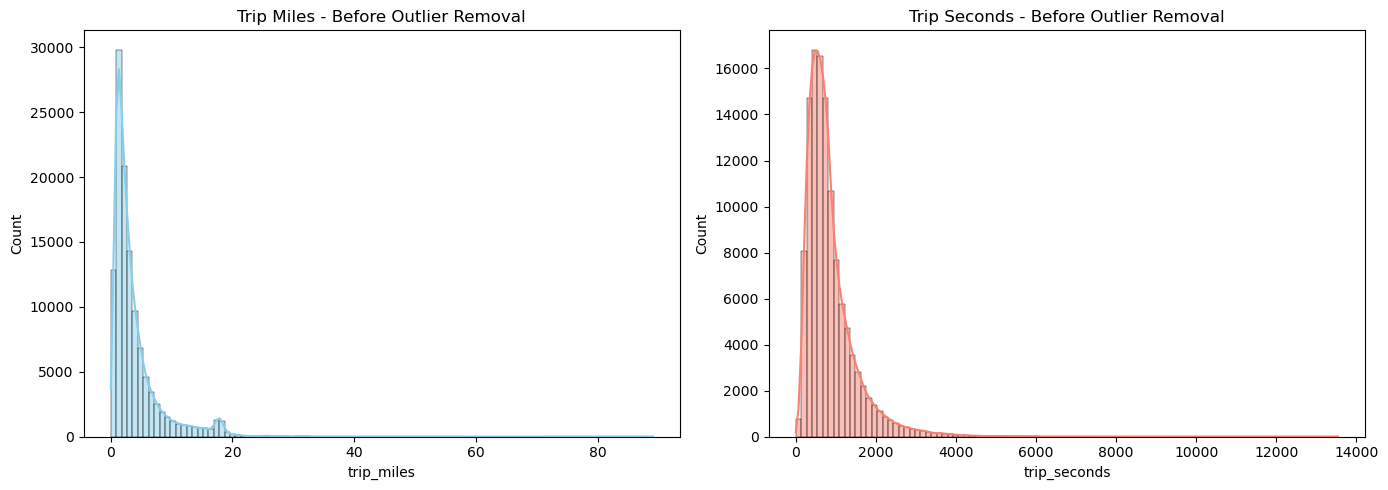

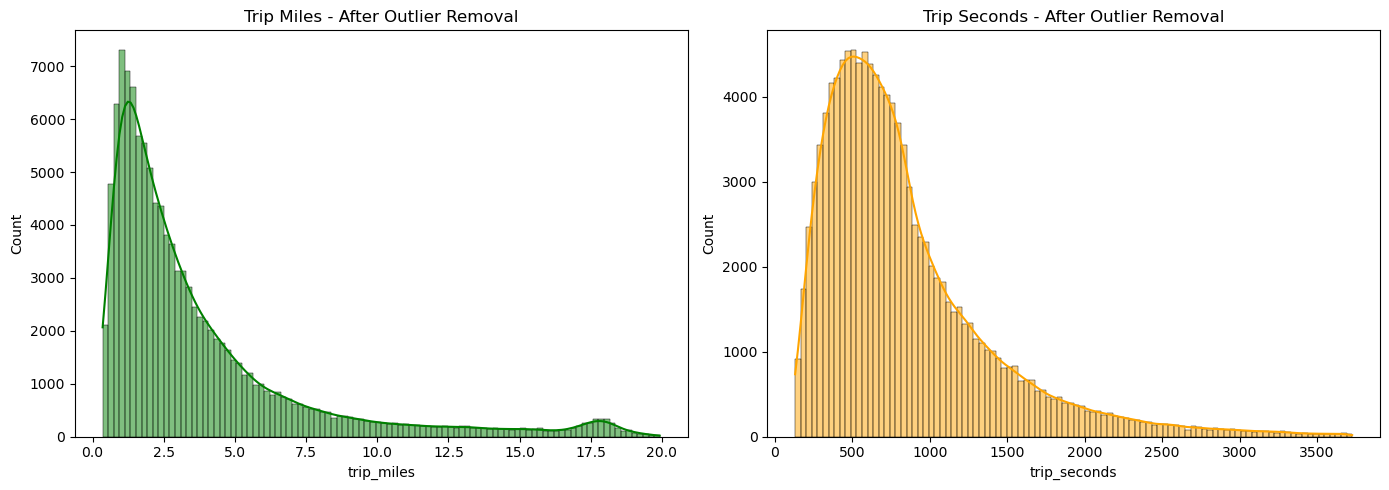

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

# Defining quantiles/ identifying extreme values using quantiles (help from: https://stackoverflow.com/questions/23199796/detect-and-exclude-outliers-in-a-pandas-dataframe)
q_low_miles = rds_cleaned['trip_miles'].quantile(0.005)
q_hi_miles = rds_cleaned['trip_miles'].quantile(0.995)
q_low_seconds = rds_cleaned['trip_seconds'].quantile(0.005)
q_hi_seconds = rds_cleaned['trip_seconds'].quantile(0.995)

# Print the thresholds
print("Quantile Thresholds: ")
print(f"trip_miles lower 0.5% quantile: {q_low_miles}")
print(f"trip_miles upper 99.5% quantile: {q_hi_miles}")
print(f"trip_seconds lower 0.5% quantile: {q_low_seconds}")
print(f"trip_seconds upper 99.5% quantile: {q_hi_seconds}")

# Find out how many trips are outside "normal" range
extreme_miles = rds_cleaned[(rds_cleaned['trip_miles'] < q_low_miles) | (rds_cleaned['trip_miles'] > q_hi_miles)]
extreme_seconds = rds_cleaned[(rds_cleaned['trip_seconds'] < q_low_seconds) | (rds_cleaned['trip_seconds'] > q_hi_seconds)]
print(f"\nExtreme trip_miles: {len(extreme_miles)} rows")
print(f"Extreme trip_seconds: {len(extreme_seconds)} rows\n")

# Visualize before filtering (by ChatGPT)
fig, axs = plt.subplots(1, 2, figsize=(14, 5))
sns.histplot(rds_cleaned['trip_miles'], bins=100, kde=True, ax=axs[0], color='skyblue')
axs[0].set_title('Trip Miles - Before Outlier Removal')
sns.histplot(rds_cleaned['trip_seconds'], bins=100, kde=True, ax=axs[1], color='salmon')
axs[1].set_title('Trip Seconds - Before Outlier Removal')
plt.tight_layout()
plt.show()

# Filter out the outliers (outside 1st and 99th percentiles)
rds_cleaned = rds_cleaned[
    (rds_cleaned['trip_miles'] > q_low_miles) & (rds_cleaned['trip_miles'] < q_hi_miles) &
    (rds_cleaned['trip_seconds'] > q_low_seconds) & (rds_cleaned['trip_seconds'] < q_hi_seconds)
]

# Visualize after (by ChatGPT)
fig, axs = plt.subplots(1, 2, figsize=(14, 5))
sns.histplot(rds_cleaned['trip_miles'], bins=100, kde=True, ax=axs[0], color='green')
axs[0].set_title('Trip Miles - After Outlier Removal')
sns.histplot(rds_cleaned['trip_seconds'], bins=100, kde=True, ax=axs[1], color='orange')
axs[1].set_title('Trip Seconds - After Outlier Removal')
plt.tight_layout()
plt.show()

**Exploring Other "Non-Sensical" Records**

After outlier handling, we thought about other variables that could result in non-sensical outlier data, e.g. if the fare costs or total trip costs equal to 0$.
Apparently there are few rows where that condition is met (see below). 

Even though those could be erroneus records, we decided to keep them, since they could simply indicate free rides or promotional offers. Apart from that the outliers for trip_seconds and trip_miles were far more relevant to catch and we thought them to be more important to handle delicately and cautiously.

In [193]:
#print("Data, where fare-costs = 0$:")
#rds_cleaned[rds_cleaned['fare'] == 0]

print("\nData, where total = 0$:")
rds_cleaned[rds_cleaned['trip_total'] == 0]



Data, where total = 0$:


,trip_id,trip_start_timestamp,trip_end_timestamp,trip_seconds,trip_miles,pickup_census_tract,dropoff_census_tract,pickup_community_area,dropoff_community_area,fare,additional_charges,trip_total,trips_pooled,pickup_centroid_latitude,pickup_centroid_longitude,pickup_centroid_location,dropoff_centroid_latitude,dropoff_centroid_longitude,dropoff_centroid_location
107257,da34a1d6eb7f7c4281464da6bd6c9daf7f4606e9,2024-05-02 20:15:00,2024-05-02T20:15:00.000,405,1.38,1.703103e+10,1.703103e+10,77.0,3.0,0.0,0.0,0.0,1,41.985472,-87.653794,POINT (-87.6537935286 41.9854724225),41.972710,-87.657341,POINT (-87.6573411073 41.9727095466)
110308,a5477a31a5882204f5769d4ce6fc4e1304279c55,2024-05-13 09:00:00,2024-05-13T09:15:00.000,1251,4.84,1.703106e+10,1.703114e+10,6.0,14.0,0.0,0.0,0.0,1,41.952719,-87.660504,POINT (-87.6605035019 41.952719111),41.971539,-87.738937,POINT (-87.7389372047 41.97153938)
110801,f9e6324354d59c49bbb831cf438950119998cdc7,2024-05-15 10:00:00,2024-05-15T10:30:00.000,1390,9.15,1.703168e+10,1.703184e+10,68.0,28.0,0.0,0.0,0.0,1,41.769190,-87.638497,POINT (-87.6384969156 41.7691898164),41.870415,-87.675086,POINT (-87.6750856208 41.8704150003)
115746,15e858b3aed0d37c19b64379b3445aca3fe49e29,2024-05-31 18:15:00,2024-05-31T19:00:00.000,2557,9.93,1.703184e+10,1.703116e+10,34.0,16.0,0.0,0.0,0.0,1,41.851018,-87.635092,POINT (-87.6350918563 41.8510178239),41.949974,-87.730684,POINT (-87.7306842554 41.9499744545)
116113,bdced6d3d510be85ab05a556c30c5a36afe3ae0f,2024-06-01 08:15:00,2024-06-01T08:30:00.000,515,1.46,1.703183e+10,1.703143e+10,43.0,43.0,0.0,0.0,0.0,1,41.755568,-87.583607,POINT (-87.5836072899 41.7555681774),41.758408,-87.562847,POINT (-87.5628473838 41.7584079022)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
194370,49e571e9575a4fa532eed9155b6709bb8c62a7f0,2024-12-21 14:15:00,2024-12-21T14:30:00.000,989,4.79,1.703166e+10,1.703173e+10,66.0,73.0,0.0,0.0,0.0,1,41.773848,-87.681095,POINT (-87.6810946628 41.7738480353),41.726835,-87.657899,POINT (-87.6578992921 41.7268354017)
196413,18f77937a65d54522552361d97bab84d8399789d,2024-12-24 19:30:00,2024-12-24T20:00:00.000,1266,9.35,1.703149e+10,1.703139e+10,49.0,39.0,0.0,0.0,0.0,1,41.703280,-87.615326,POINT (-87.6153264942 41.7032802648),41.805925,-87.604059,POINT (-87.6040586249 41.8059249688)
197758,271d130181807c5b3a7e22cbd488ddae3a637563,2024-12-27 16:30:00,2024-12-27T17:00:00.000,1942,6.99,1.703105e+10,1.703126e+10,5.0,26.0,0.0,0.0,0.0,1,41.950443,-87.683506,POINT (-87.6835062305 41.9504425991),41.877101,-87.723077,POINT (-87.7230765587 41.8771009333)
198298,d147f1133b7df543bb3639e6ad1bf0fe06c5dd3c,2024-12-28 12:15:00,2024-12-28T12:30:00.000,1011,5.80,1.703166e+10,1.703183e+10,66.0,49.0,0.0,0.0,0.0,1,41.768106,-87.698001,POINT (-87.6980008039 41.7681062939),41.727585,-87.629566,POINT (-87.6295663156 41.7275849467)


### 3. Feature Engineering ⚙️

After cleaning our data a bit, we will update `rds` to be our `rds_cleaned` version for further usage. Also, we now have **116k (116.261) rows** left.

Note (*by ChatGPT*, since we encountered an "issue" below, trying to convert datatypes): 
When working with slices of a DataFrame, pandas may display a SettingWithCopyWarning to prevent unexpected behavior. To avoid this, we either use .loc for assignment or create a full .copy() of the DataFrame before modifying it. This ensures that our data transformations are applied safely and as intended.

In [10]:
rds = rds_cleaned.copy() # We're making a deep copy
rds

,trip_id,trip_start_timestamp,trip_end_timestamp,trip_seconds,trip_miles,pickup_census_tract,dropoff_census_tract,pickup_community_area,dropoff_community_area,fare,additional_charges,trip_total,trips_pooled,pickup_centroid_latitude,pickup_centroid_longitude,pickup_centroid_location,dropoff_centroid_latitude,dropoff_centroid_longitude,dropoff_centroid_location
2,81677cd093e06b90597463d8c7441c01917660a8,2023-02-01 00:15:00,2023-02-01T00:15:00.000,224,0.68,1.703108e+10,1.703108e+10,8.0,8.0,15.0,1.29,16.29,1,41.900266,-87.632109,POINT (-87.6321092196 41.9002656868),41.898332,-87.620763,POINT (-87.6207628651 41.8983317935)
3,f1f2553ad5626b712119208cfbb30c56e70faba8,2023-02-01 00:30:00,2023-02-01T00:45:00.000,276,1.48,1.703184e+10,1.703184e+10,28.0,28.0,15.0,1.29,16.29,1,41.863118,-87.672920,POINT (-87.672920435 41.8631181033),41.867902,-87.642959,POINT (-87.6429586652 41.8679024175)
5,7da0202a6fbb5d3ad648f74e1255fa39cb3cfc72,2023-02-01 01:15:00,2023-02-01T01:30:00.000,386,1.09,1.703133e+10,1.703133e+10,33.0,33.0,10.0,1.29,11.29,1,41.859350,-87.617358,POINT (-87.6173580061 41.859349715),41.859350,-87.617358,POINT (-87.6173580061 41.859349715)
14,4d1d31d1925bbef1970851dcf0bf83bfb7f3c7a6,2023-02-01 05:15:00,2023-02-01T05:30:00.000,1174,11.12,1.703128e+10,1.703198e+10,28.0,56.0,40.0,6.29,46.29,1,41.879255,-87.642649,POINT (-87.642648998 41.8792550844),41.785999,-87.750934,POINT (-87.7509342894 41.785998518)
16,b5fe166c3b2ce8aefe233cb0d4ad72422c68dcde,2023-02-01 05:45:00,2023-02-01T05:45:00.000,182,0.39,1.703184e+10,1.703132e+10,32.0,32.0,12.5,1.29,13.79,1,41.880994,-87.632746,POINT (-87.6327464887 41.8809944707),41.884987,-87.620993,POINT (-87.6209929134 41.8849871918)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
199992,91237682ef5689c455e491cba3885afb050bdeb4,2024-12-30 23:45:00,2024-12-30T23:45:00.000,296,1.03,1.703106e+10,1.703106e+10,6.0,6.0,5.0,1.23,6.23,1,41.942585,-87.656644,POINT (-87.6566440918 41.9425851797),41.936310,-87.651563,POINT (-87.6515625922 41.9363101308)
199994,8a7e2464eba0831dd3e57e0a31a3d7bf0689737b,2024-12-30 23:45:00,2024-12-30T23:45:00.000,283,0.71,1.703184e+10,1.703108e+10,24.0,8.0,5.0,1.23,6.23,1,41.898306,-87.653614,POINT (-87.6536139825 41.8983058696),41.893216,-87.637844,POINT (-87.6378442095 41.8932163595)
199995,8af6bcffb5ca61956ae356a9e6b07f4aa89e1650,2024-12-30 23:45:00,2024-12-31T00:00:00.000,836,7.86,1.703133e+10,1.703122e+10,33.0,22.0,15.0,1.23,16.23,1,41.859350,-87.617358,POINT (-87.6173580061 41.859349715),41.921126,-87.699754,POINT (-87.6997544065 41.9211259143)
199996,0b05da87638038b62904989809391adc56bf3fe1,2024-12-30 23:45:00,2024-12-30T23:45:00.000,287,0.81,1.703183e+10,1.703128e+10,28.0,28.0,5.0,1.23,6.23,1,41.885281,-87.657233,POINT (-87.6572331997 41.8852813201),41.879255,-87.642649,POINT (-87.642648998 41.8792550844)


#### I) Convert Datatypes (if/ where needed) 🔁

Before converting any column data types, we first inspect the current types in the dataset.
Here, we see that the timestamp columns are of type `object`, which means they are being treated as plain text. For proper time-based analysis, we need to convert these columns to `datetime` format.

In [224]:
# Show data types of all columns
print(rds.dtypes)

trip_id                        object
trip_start_timestamp           object
trip_end_timestamp             object
trip_seconds                    int64
trip_miles                    float64
pickup_census_tract           float64
dropoff_census_tract          float64
pickup_community_area         float64
dropoff_community_area        float64
fare                          float64
additional_charges            float64
trip_total                    float64
trips_pooled                    int64
pickup_centroid_latitude      float64
pickup_centroid_longitude     float64
pickup_centroid_location       object
dropoff_centroid_latitude     float64
dropoff_centroid_longitude    float64
dropoff_centroid_location      object
dtype: object


**Now, we convert** the `trip_start_timestamp` and `trip_end_timestamp` columns into pandas `datetime` format (and rename them), to enable us to extract time features such as *hour of the day*, *day of the week*, etc. We use `errors='coerce'` to safely handle any invalid entries, which are converted to `NaT` (Not a Time).

In [11]:
# Convert trip_start_timestamp and trip_end_timestamp to datetime
rds['trip_start_timestamp'] = pd.to_datetime(rds['trip_start_timestamp'], errors='coerce')
rds['trip_end_timestamp'] = pd.to_datetime(rds['trip_end_timestamp'], errors='coerce')

# Check the datatypes again
print(rds.dtypes)

trip_id                               object
trip_start_timestamp          datetime64[ns]
trip_end_timestamp            datetime64[ns]
trip_seconds                           int64
trip_miles                           float64
pickup_census_tract                  float64
dropoff_census_tract                 float64
pickup_community_area                float64
dropoff_community_area               float64
fare                                 float64
additional_charges                   float64
trip_total                           float64
trips_pooled                           int64
pickup_centroid_latitude             float64
pickup_centroid_longitude            float64
pickup_centroid_location              object
dropoff_centroid_latitude            float64
dropoff_centroid_longitude           float64
dropoff_centroid_location             object
dtype: object


#### II) Extract Time Features ⏰

We extract components of the `trip_start_timestamp` such as:
- **Hour of the day**: potentially helpful for identifying rush hours for example.
- **Day and Month**: useful for analyzing trends over time.
- **Day of Week and Weekend**: useful to detect during-the-week trip patterns or weekday vs weekend patterns.

In [12]:
# Extract time-based features from trip_start_timestamp
rds['start_hour'] = rds['trip_start_timestamp'].dt.hour # between 0 and 23
rds['trip_day'] = rds['trip_start_timestamp'].dt.day # between 1 and 31
rds['trip_month'] = rds['trip_start_timestamp'].dt.month # between 1 and 12
rds['trip_dayofweek'] = rds['trip_start_timestamp'].dt.dayofweek  # Monday = 0, …, Sunday = 6
rds['is_weekend'] = rds['trip_dayofweek'].isin([5, 6]).astype(int) # idea from ChatGPT

#### III) Adding Weather Data 🌦️

In [13]:
from datetime import datetime
from meteostat import Point, Hourly


rds['start_date_and_hour'] = pd.to_datetime(rds['trip_start_timestamp'])
rds['end_date_and_hour'] = pd.to_datetime(rds['trip_end_timestamp'])


areas1 = rds.groupby('pickup_community_area').agg({'start_date_and_hour': ['min'], 'pickup_centroid_latitude': ['first'], 'pickup_centroid_longitude' : ['first']})
areas2 = rds.groupby('pickup_community_area').agg({'start_date_and_hour': ['max'], 'dropoff_centroid_latitude': ['first'], 'dropoff_centroid_longitude' : ['first']})

areas = pd.merge(areas1, areas2, left_index=True, right_index=True)
areas.columns = ['start', 'pickup_centroid_latitude',	'pickup_centroid_longitude', 'end', 'dropoff_centroid_latitude', 'dropoff_centroid_longitude']
areas

weather_pickup = []
weather_dropoff = []

for index, row in areas.iterrows():
    location_pickup = Point(row['pickup_centroid_latitude'],row['pickup_centroid_longitude'])
    weather_1 = Hourly(location_pickup, row['start'], row['end'])
    weather_df_1 = weather_1.fetch()
    weather_pickup.append(weather_df_1)


for index, row in areas.iterrows():
    location_dropoff = Point(row['dropoff_centroid_latitude'],row['dropoff_centroid_longitude'])
    weather_2 = Hourly(location_dropoff, row['start'], row['end'])
    weather_df_2 = weather_2.fetch()
    weather_dropoff.append(weather_df_2)

# Combine into dataframes
weather_df_pickup = pd.concat(weather_pickup).reset_index()
weather_df_dropoff = pd.concat(weather_dropoff).reset_index()

# Merge pickup and dropoff weather data
weather_df = pd.merge(weather_df_pickup, weather_df_dropoff, right_index=True, left_index=True, suffixes=['_pickup', '_dropoff'])

# Rename time column for merging later
weather_df.rename(columns={'time_pickup': 'trip_start_timestamp'}, inplace=True)

# Preview weather data
weather_df

,trip_start_timestamp,temp_pickup,dwpt_pickup,rhum_pickup,prcp_pickup,snow_pickup,wdir_pickup,wspd_pickup,wpgt_pickup,pres_pickup,...,dwpt_dropoff,rhum_dropoff,prcp_dropoff,snow_dropoff,wdir_dropoff,wspd_dropoff,wpgt_dropoff,pres_dropoff,tsun_dropoff,coco_dropoff
0,2023-02-02 09:00:00,-5.0,-12.6,62.0,0.0,<NA>,220.0,22.3,<NA>,1020.8,...,-12.6,65.0,0.0,<NA>,220.0,18.4,<NA>,1022.3,<NA>,1.0
1,2023-02-02 10:00:00,-5.0,-13.2,59.0,0.0,<NA>,230.0,22.3,<NA>,1020.6,...,-12.5,68.0,0.0,<NA>,220.0,16.6,<NA>,1022.0,<NA>,1.0
2,2023-02-02 11:00:00,-5.6,-13.2,62.0,0.0,<NA>,220.0,20.5,<NA>,1020.4,...,-12.5,68.0,0.0,<NA>,220.0,16.6,<NA>,1021.8,<NA>,1.0
3,2023-02-02 12:00:00,-5.6,-13.2,62.0,0.0,<NA>,220.0,18.4,<NA>,1019.7,...,-12.5,68.0,0.0,<NA>,230.0,13.0,<NA>,1021.2,<NA>,1.0
4,2023-02-02 13:00:00,-6.1,-13.1,65.0,0.0,<NA>,230.0,16.6,<NA>,1019.2,...,-12.5,68.0,0.0,<NA>,230.0,16.6,<NA>,1020.7,<NA>,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1253942,2024-12-30 16:00:00,1.1,-0.5,92.0,0.0,<NA>,240.0,9.4,<NA>,1010.0,...,-0.5,92.0,0.0,<NA>,240.0,9.4,<NA>,1010.0,<NA>,5.0
1253943,2024-12-30 17:00:00,2.8,-0.2,85.0,0.0,<NA>,230.0,7.6,<NA>,1009.5,...,-0.2,85.0,0.0,<NA>,230.0,7.6,<NA>,1009.5,<NA>,4.0
1253944,2024-12-30 18:00:00,5.0,0.8,79.0,0.0,<NA>,200.0,13.0,<NA>,1009.2,...,0.8,79.0,0.0,<NA>,200.0,13.0,<NA>,1009.2,<NA>,4.0
1253945,2024-12-30 19:00:00,4.4,0.2,79.0,0.0,<NA>,220.0,14.8,<NA>,1008.6,...,0.2,79.0,0.0,<NA>,220.0,14.8,<NA>,1008.6,<NA>,4.0


In [14]:
# Make sure trip_start_timestamp in weather_df is datetime
weather_df['trip_start_timestamp'] = pd.to_datetime(weather_df['trip_start_timestamp'])

# Then sort
rds.sort_values('trip_start_timestamp', inplace=True)
weather_df.sort_values('trip_start_timestamp', inplace=True)

# Merge
weather_rds = pd.merge_asof(rds, weather_df, on='trip_start_timestamp', direction='nearest')
weather_rds

,trip_id,trip_start_timestamp,trip_end_timestamp,trip_seconds,trip_miles,pickup_census_tract,dropoff_census_tract,pickup_community_area,dropoff_community_area,fare,...,dwpt_dropoff,rhum_dropoff,prcp_dropoff,snow_dropoff,wdir_dropoff,wspd_dropoff,wpgt_dropoff,pres_dropoff,tsun_dropoff,coco_dropoff
0,81677cd093e06b90597463d8c7441c01917660a8,2023-02-01 00:15:00,2023-02-01 00:15:00,224,0.68,1.703108e+10,1.703108e+10,8.0,8.0,15.0,...,-23.5,49.0,0.0,<NA>,240.0,13.0,<NA>,1030.7,<NA>,1.0
1,f1f2553ad5626b712119208cfbb30c56e70faba8,2023-02-01 00:30:00,2023-02-01 00:45:00,276,1.48,1.703184e+10,1.703184e+10,28.0,28.0,15.0,...,-23.5,49.0,0.0,<NA>,240.0,13.0,<NA>,1030.7,<NA>,1.0
2,7da0202a6fbb5d3ad648f74e1255fa39cb3cfc72,2023-02-01 01:15:00,2023-02-01 01:30:00,386,1.09,1.703133e+10,1.703133e+10,33.0,33.0,10.0,...,-23.5,49.0,0.0,<NA>,240.0,13.0,<NA>,1030.7,<NA>,1.0
3,4d1d31d1925bbef1970851dcf0bf83bfb7f3c7a6,2023-02-01 05:15:00,2023-02-01 05:30:00,1174,11.12,1.703128e+10,1.703198e+10,28.0,56.0,40.0,...,-22.6,59.0,0.0,<NA>,250.0,11.2,<NA>,1030.9,<NA>,1.0
4,b5fe166c3b2ce8aefe233cb0d4ad72422c68dcde,2023-02-01 05:45:00,2023-02-01 05:45:00,182,0.39,1.703184e+10,1.703132e+10,32.0,32.0,12.5,...,-22.0,62.0,0.0,<NA>,250.0,13.0,<NA>,1030.6,<NA>,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
116256,8af6bcffb5ca61956ae356a9e6b07f4aa89e1650,2024-12-30 23:45:00,2024-12-31 00:00:00,836,7.86,1.703133e+10,1.703122e+10,33.0,22.0,15.0,...,0.2,79.0,0.0,<NA>,170.0,5.4,<NA>,1008.6,<NA>,3.0
116257,0b05da87638038b62904989809391adc56bf3fe1,2024-12-30 23:45:00,2024-12-30 23:45:00,287,0.81,1.703183e+10,1.703128e+10,28.0,28.0,5.0,...,0.2,79.0,0.0,<NA>,170.0,5.4,<NA>,1008.6,<NA>,3.0
116258,91237682ef5689c455e491cba3885afb050bdeb4,2024-12-30 23:45:00,2024-12-30 23:45:00,296,1.03,1.703106e+10,1.703106e+10,6.0,6.0,5.0,...,0.2,79.0,0.0,<NA>,170.0,5.4,<NA>,1008.6,<NA>,3.0
116259,8a7e2464eba0831dd3e57e0a31a3d7bf0689737b,2024-12-30 23:45:00,2024-12-30 23:45:00,283,0.71,1.703184e+10,1.703108e+10,24.0,8.0,5.0,...,0.2,79.0,0.0,<NA>,170.0,5.4,<NA>,1008.6,<NA>,3.0


##### Addition to Understand the Weather Data

**Weather Data Abbreviations Meaning** *by ChatGPT*
| Abbreviation | Full Name                  | Description                                      | Units         |
|--------------|----------------------------|--------------------------------------------------|---------------|
| temp         | Temperature                | Air temperature                                  | °C            |
| dwpt         | Dew Point Temperature      | Temperature at which air becomes saturated       | °C            |
| rhum         | Relative Humidity          | Amount of moisture in the air                    | % (0–100)     |
| prcp         | Precipitation              | Total rain/snow/sleet/drizzle                    | mm            |
| snow         | Snowfall                   | Amount of snow                                   | mm            |
| wspd         | Wind Speed                 | Average hourly wind speed                        | km/h          |
| wpgt         | Wind Gust                  | Max wind speed (gusts)                           | km/h          |
| pres         | Pressure                   | Sea-level atmospheric pressure                   | hPa           |
| tsun         | Sunshine Duration          | Total minutes of sun in the hour                 | minutes       |
| coco         | Weather Condition Code     | Integer code for observed weather condition      | Integer       |

**Weather Condition Codes `coco`**
| Code | Description            |
|------|------------------------|
| 0    | Clear                  |
| 1    | Fair                   |
| 2    | Partly Cloudy          |
| 3    | Cloudy                 |
| 4    | Overcast               |
| 5    | Rain                   |
| 6    | Freezing Rain          |
| 7    | Showers                |
| 8    | Snow                   |
| 9    | Snowfall               |
| 10   | Snow Showers           |
| 11   | Mixed Rain/Snow        |
| 12   | Mixed Rain/Snow Showers|
| 13   | Freezing Drizzle       |
| 14   | Thunderstorm           |
| 15   | Fog                    |


**Interpreting `prcp` (precipitation) - When is it Raining?**

| Precipitation (mm/hour) | Description        | Typical Weather     |
|--------------------------|--------------------|----------------------|
| 0                        | None               | Clear / Dry         |
| 0.01 – 0.2               | Very Light Rain    | Mist / Drizzle      |
| 0.2 – 1.0                | Light Rain         | Intermittent        |
| 1.0 – 4.0                | Moderate Rain      | Steady Rainfall     |
| 4.0+                     | Heavy Rain         | Downpour            |



#### IV) Second Clean-Up 🧹

Now, we'd like to do a second round of cleaning the new `weather_rds` data, similarly to the steps we took previously in our "Data Cleaning 🧼".

**First**, remove rows with missing or obviously invalid weather data/ look for missing or nonsensical weather data especially at pickup time.

In [ ]:
# Identify weather columns (asked ChatGPT for this)
weather_columns = [col for col in weather_rds.columns if any(w in col for w in [
    'temp', 'prcp', 'wspd', 'wpgt', 'snow', 'tsun', 'rhum', 'dwpt', 'pres', 'coco'
])]

# Count missing weather values per row
weather_rds['missing_weather_count'] = weather_rds[weather_columns].isnull().sum(axis=1)
# Get …
weather_rds['missing_weather_count'].unique()



array([ 6,  8,  7, 10,  9, 12])

Here, we can see that every row has at least 6 missing values for weather columns.
So, simply checking for nulls in weather fields and removing those rows is not an option, since that would mean we would have to remove all rows :). 
Therefore, we'll check **for which 6 columns the values are always missing**…

In [ ]:
# Create a missing value summary
missing_weather_summary = weather_rds[weather_columns].isnull().sum().to_frame(name='Missing Values')
missing_weather_summary['% of Total'] = (missing_weather_summary['Missing Values'] / len(weather_rds)) * 100

# Sort & show
missing_weather_summary = missing_weather_summary[missing_weather_summary['Missing Values'] > 0]
missing_weather_summary.sort_values('Missing Values', ascending=False, inplace=True)

missing_weather_summary

,Missing Values,% of Total
snow_pickup,116261,100.000000
wpgt_pickup,116261,100.000000
snow_dropoff,116261,100.000000
tsun_pickup,116261,100.000000
tsun_dropoff,116261,100.000000
wpgt_dropoff,116261,100.000000
prcp_dropoff,2489,2.140873
prcp_pickup,2326,2.000671
coco_pickup,1486,1.278159
coco_dropoff,946,0.813686


Thankfully, the (for us) seemingly most important weather-based columns like temperature, rain, windspeed are not really effected by missing values.

We'll now **remove** the 6 rows with a 100% missing rate (snow_pickup/dropoff, wpgt_pickup/dropoff, tsun_pickup/dropoff)…

In [25]:
weather_rds_clean = weather_rds

cols_to_drop = [
    'snow_pickup', 'snow_dropoff',
    'wpgt_pickup', 'wpgt_dropoff',
    'tsun_pickup', 'tsun_dropoff'
]

weather_rds_clean = weather_rds.drop(columns=cols_to_drop)
weather_rds_clean

,trip_id,trip_start_timestamp,trip_end_timestamp,trip_seconds,trip_miles,pickup_census_tract,dropoff_census_tract,pickup_community_area,dropoff_community_area,fare,...,time_dropoff,temp_dropoff,dwpt_dropoff,rhum_dropoff,prcp_dropoff,wdir_dropoff,wspd_dropoff,pres_dropoff,coco_dropoff,missing_weather_count
0,81677cd093e06b90597463d8c7441c01917660a8,2023-02-01 00:15:00,2023-02-01 00:15:00,224,0.68,1.703108e+10,1.703108e+10,8.0,8.0,15.0,...,2023-02-01 01:00:00,-13.3,-23.5,49.0,0.0,240.0,13.0,1030.7,1.0,6
1,f1f2553ad5626b712119208cfbb30c56e70faba8,2023-02-01 00:30:00,2023-02-01 00:45:00,276,1.48,1.703184e+10,1.703184e+10,28.0,28.0,15.0,...,2023-02-01 01:00:00,-13.3,-23.5,49.0,0.0,240.0,13.0,1030.7,1.0,6
2,7da0202a6fbb5d3ad648f74e1255fa39cb3cfc72,2023-02-01 01:15:00,2023-02-01 01:30:00,386,1.09,1.703133e+10,1.703133e+10,33.0,33.0,10.0,...,2023-02-01 01:00:00,-13.3,-23.5,49.0,0.0,240.0,13.0,1030.7,1.0,6
3,4d1d31d1925bbef1970851dcf0bf83bfb7f3c7a6,2023-02-01 05:15:00,2023-02-01 05:30:00,1174,11.12,1.703128e+10,1.703198e+10,28.0,56.0,40.0,...,2023-02-01 05:00:00,-14.4,-22.6,59.0,0.0,250.0,11.2,1030.9,1.0,6
4,b5fe166c3b2ce8aefe233cb0d4ad72422c68dcde,2023-02-01 05:45:00,2023-02-01 05:45:00,182,0.39,1.703184e+10,1.703132e+10,32.0,32.0,12.5,...,2023-02-01 06:00:00,-14.4,-22.0,62.0,0.0,250.0,13.0,1030.6,1.0,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
116256,8af6bcffb5ca61956ae356a9e6b07f4aa89e1650,2024-12-30 23:45:00,2024-12-31 00:00:00,836,7.86,1.703133e+10,1.703122e+10,33.0,22.0,15.0,...,2024-12-30 23:00:00,4.4,0.2,79.0,0.0,170.0,5.4,1008.6,3.0,6
116257,0b05da87638038b62904989809391adc56bf3fe1,2024-12-30 23:45:00,2024-12-30 23:45:00,287,0.81,1.703183e+10,1.703128e+10,28.0,28.0,5.0,...,2024-12-30 23:00:00,4.4,0.2,79.0,0.0,170.0,5.4,1008.6,3.0,6
116258,91237682ef5689c455e491cba3885afb050bdeb4,2024-12-30 23:45:00,2024-12-30 23:45:00,296,1.03,1.703106e+10,1.703106e+10,6.0,6.0,5.0,...,2024-12-30 23:00:00,4.4,0.2,79.0,0.0,170.0,5.4,1008.6,3.0,6
116259,8a7e2464eba0831dd3e57e0a31a3d7bf0689737b,2024-12-30 23:45:00,2024-12-30 23:45:00,283,0.71,1.703184e+10,1.703108e+10,24.0,8.0,5.0,...,2024-12-30 23:00:00,4.4,0.2,79.0,0.0,170.0,5.4,1008.6,3.0,6


Now, to finsih up the handling of missing values, let's have another look at the other 'Missing Value' entries in weather-based features and remove those specific rows, that obtain them:

In [ ]:
# 2. Re-identify weather columns after drop
weather_columns_clean = [col for col in weather_rds_clean.columns if any(w in col for w in [
    'temp', 'prcp', 'wspd', 'rhum', 'dwpt', 'pres', 'coco'  # dropped snow, wpgt, tsun
])]

# Create a missing value summary
missing_weather_summary = weather_rds_clean[weather_columns_clean].isnull().sum().to_frame(name='Missing Values')
missing_weather_summary['% of Total'] = (missing_weather_summary['Missing Values'] / len(weather_rds_clean)) * 100

# Sort & show
missing_weather_summary = missing_weather_summary[missing_weather_summary['Missing Values'] > 0]
missing_weather_summary.sort_values('Missing Values', ascending=False, inplace=True)

missing_weather_summary


,Missing Values,% of Total
prcp_dropoff,2489,2.140873
prcp_pickup,2326,2.000671
coco_pickup,1486,1.278159
coco_dropoff,946,0.813686
pres_pickup,26,0.022363
pres_dropoff,5,0.004301


In [34]:
# Drop all rows that have any missing values in those weather columns
weather_rds_clean = weather_rds_clean.dropna(subset=weather_columns_clean)
weather_rds_clean

,trip_id,trip_start_timestamp,trip_end_timestamp,trip_seconds,trip_miles,pickup_census_tract,dropoff_census_tract,pickup_community_area,dropoff_community_area,fare,...,time_dropoff,temp_dropoff,dwpt_dropoff,rhum_dropoff,prcp_dropoff,wdir_dropoff,wspd_dropoff,pres_dropoff,coco_dropoff,missing_weather_count
0,81677cd093e06b90597463d8c7441c01917660a8,2023-02-01 00:15:00,2023-02-01 00:15:00,224,0.68,1.703108e+10,1.703108e+10,8.0,8.0,15.0,...,2023-02-01 01:00:00,-13.3,-23.5,49.0,0.0,240.0,13.0,1030.7,1.0,6
1,f1f2553ad5626b712119208cfbb30c56e70faba8,2023-02-01 00:30:00,2023-02-01 00:45:00,276,1.48,1.703184e+10,1.703184e+10,28.0,28.0,15.0,...,2023-02-01 01:00:00,-13.3,-23.5,49.0,0.0,240.0,13.0,1030.7,1.0,6
2,7da0202a6fbb5d3ad648f74e1255fa39cb3cfc72,2023-02-01 01:15:00,2023-02-01 01:30:00,386,1.09,1.703133e+10,1.703133e+10,33.0,33.0,10.0,...,2023-02-01 01:00:00,-13.3,-23.5,49.0,0.0,240.0,13.0,1030.7,1.0,6
3,4d1d31d1925bbef1970851dcf0bf83bfb7f3c7a6,2023-02-01 05:15:00,2023-02-01 05:30:00,1174,11.12,1.703128e+10,1.703198e+10,28.0,56.0,40.0,...,2023-02-01 05:00:00,-14.4,-22.6,59.0,0.0,250.0,11.2,1030.9,1.0,6
4,b5fe166c3b2ce8aefe233cb0d4ad72422c68dcde,2023-02-01 05:45:00,2023-02-01 05:45:00,182,0.39,1.703184e+10,1.703132e+10,32.0,32.0,12.5,...,2023-02-01 06:00:00,-14.4,-22.0,62.0,0.0,250.0,13.0,1030.6,1.0,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
116256,8af6bcffb5ca61956ae356a9e6b07f4aa89e1650,2024-12-30 23:45:00,2024-12-31 00:00:00,836,7.86,1.703133e+10,1.703122e+10,33.0,22.0,15.0,...,2024-12-30 23:00:00,4.4,0.2,79.0,0.0,170.0,5.4,1008.6,3.0,6
116257,0b05da87638038b62904989809391adc56bf3fe1,2024-12-30 23:45:00,2024-12-30 23:45:00,287,0.81,1.703183e+10,1.703128e+10,28.0,28.0,5.0,...,2024-12-30 23:00:00,4.4,0.2,79.0,0.0,170.0,5.4,1008.6,3.0,6
116258,91237682ef5689c455e491cba3885afb050bdeb4,2024-12-30 23:45:00,2024-12-30 23:45:00,296,1.03,1.703106e+10,1.703106e+10,6.0,6.0,5.0,...,2024-12-30 23:00:00,4.4,0.2,79.0,0.0,170.0,5.4,1008.6,3.0,6
116259,8a7e2464eba0831dd3e57e0a31a3d7bf0689737b,2024-12-30 23:45:00,2024-12-30 23:45:00,283,0.71,1.703184e+10,1.703108e+10,24.0,8.0,5.0,...,2024-12-30 23:00:00,4.4,0.2,79.0,0.0,170.0,5.4,1008.6,3.0,6


In [ ]:
# Addition to check amount of dropped rows
initial_count = len(weather_rds)
after_drop_count = len(weather_rds_clean)
print(f"Rows before dropping missing weather data: {initial_count}")
print(f"Rows after dropping missing weather data: {after_drop_count}")
print(f"Rows removed: {initial_count - after_drop_count}")


Rows before dropping missing weather data: 116261
Rows after dropping missing weather data: 112888
Rows removed: 3373


In [32]:
# Lastly, some cleaning validation with…
weather_rds_clean.info()
weather_rds_clean.describe()
weather_rds_clean.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
Index: 112888 entries, 0 to 116260
Data columns (total 44 columns):
 #   Column                      Non-Null Count   Dtype         
---  ------                      --------------   -----         
 0   trip_id                     112888 non-null  object        
 1   trip_start_timestamp        112888 non-null  datetime64[ns]
 2   trip_end_timestamp          112888 non-null  datetime64[ns]
 3   trip_seconds                112888 non-null  int64         
 4   trip_miles                  112888 non-null  float64       
 5   pickup_census_tract         112888 non-null  float64       
 6   dropoff_census_tract        112888 non-null  float64       
 7   pickup_community_area       112888 non-null  float64       
 8   dropoff_community_area      112888 non-null  float64       
 9   fare                        112888 non-null  float64       
 10  additional_charges          112888 non-null  float64       
 11  trip_total                  112888 non-null 

trip_id                       0
trip_start_timestamp          0
trip_end_timestamp            0
trip_seconds                  0
trip_miles                    0
pickup_census_tract           0
dropoff_census_tract          0
pickup_community_area         0
dropoff_community_area        0
fare                          0
additional_charges            0
trip_total                    0
trips_pooled                  0
pickup_centroid_latitude      0
pickup_centroid_longitude     0
pickup_centroid_location      0
dropoff_centroid_latitude     0
dropoff_centroid_longitude    0
dropoff_centroid_location     0
start_hour                    0
trip_day                      0
trip_month                    0
trip_dayofweek                0
is_weekend                    0
start_date_and_hour           0
end_date_and_hour             0
temp_pickup                   0
dwpt_pickup                   0
rhum_pickup                   0
prcp_pickup                   0
wdir_pickup                   0
wspd_pic

So, update… We now end up with **112k (112.888) rows**!

---

## First Data Exploration 🔎

After Business Understanding and Data Understanding and Preparation and before modeling or visualizing, we start by exploring key aspects of the dataset to understand patterns and context, e.g. …

- At what hour do most trips start?
- On which day of the week are most trips taken?
- What is the average traffic volume across all trips?


In [6]:
# 1. Hour with most trips
hour_counts = rds['hour'].value_counts().sort_index()
peak_hour = hour_counts.idxmax()
print(f"* Most trips start at {peak_hour}:00 with {hour_counts[peak_hour]:,} trips.")

# 2. Day with most trips
day_counts = rds['day_of_week'].value_counts().sort_index()
day_names = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
peak_day_index = day_counts.idxmax()
print(f"* Most trips happen on {day_names[peak_day_index]} with {day_counts[peak_day_index]:,} trips.")

# 3. Average traffic volume
avg_traffic_in_minutes = (rds['traffic_volume'].mean() / 60)
print(f"* The average traffic volume is {avg_traffic_in_minutes:.2f} minutes per mile.")

* Most trips start at 18:00 with 12,569 trips.
* Most trips happen on Saturday with 37,748 trips.
* The average traffic volume is 4.39 minutes per mile.


---

## Descriptive Analysis (Eeros code)